# Word Analogy using Word Embedding

Analogy  -  a thing which is comparable to something else in significant respects.

Word embedding is the collective name for a set of language modeling and feature learning techniques in natural language processing



the aim of this blog is to prove King-Men+Women=Queen



## WORD Embedding
###  is a real-valued vector representation
### of words by embedding both semantic and syntactic meanings
###  obtained from unlabeled large corpus

## Word Embedding VS Feed Forward Network

*the input of feed forward neural network must be one hot encoding to get featured vectors
  one-hot encoding  has two main drawbacks
  
> high-cardinality variables — those with many unique categories — the dimensionality of the transformed vector becomes unmanageable.

> The mapping is completely uninformed: “similar” categories are not placed closer to each other in embedding space.











## Will Feed forward Neural Network learn word Embeding ?
   Yes But .....
  


This is related to using  one-hot encoding in a sense that it maps a discrete category (embedding matrix into a vector feature representation(embedding vectors)
You could still do this for a neural network but if you use this in a dense layer you would create an enormous amount of weights of which most of them are not used regularly (one hot encoding uses many zeros). Putting an embedding layer in between reduces the amount of learnable weights (since is refernces a row and not perform any multiplication ) before feeding them to interact with other parts of your input. 
   


# Architecture
 
 it is a neural network with
 
 * input layer
 * hidden layer
 * output layer
 

In [ ]:
import pandas as pd
from string import punctuation
#available at https://www.kaggle.com/jrobischon/wikipedia-movie-plots 
df=pd.read_csv("/content/drive/My Drive/wiki_movie_plots_deduped.csv")[:15000]

clear_punct_regex = "[" + punctuation + "\d\r\n]"
corpus = df['Plot'].str.replace(clear_punct_regex, "").str.lower()
corpus = " ".join(corpus)
corpus=corpus.lower()
corpus=corpus.replace("\n,\t", "")

dataset=[]
dataset.append(corpus)
     


FileNotFoundError: ignored

In [ ]:
import nltk
from nltk.corpus import brown
def get_text_brown():
    sent= list(brown.sents())

    dataset=[]
  
    for i in sent:
        sentence=[]
        for word in i:
          if word not in ["'","(",")",".","''","''","``",","]  :
            sentence.append(word.lower())
        dataset.append(" ".join(sentence))
    print(len(dataset),"  setences")  
    return dataset

In [ ]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [ ]:
dataset=get_text_brown()

57340   setences


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


hyperparameters => window size of the context (w) (to understand context of word )

In [ ]:
import numpy as np

In [ ]:
class counter():# count the ocurences of words
    def count_words(self,corpus,word_limit=1000,clean=False):
        self.Tokens=[]
        counter={}
        for sent in corpus:
            if(clean):
                sent=self.clean(sent)
            text=sent.split() # take the required number of words
            self.Tokens.append(text)
           
            for w in text:
                if(w in counter):
                    counter[w]+=1
                else:
                    counter[w]=1
        self.C=counter
    
    def clean(string):
        stop_words=[]
        string = string.lower()
        string = re.sub(r'[^\w\s]', '', string) 
        string = ' '.join([word for word in string.split() if word not in stop_words])
        return string
    def arrange(self,o):
        return sorted(self.C.items(), key=lambda x: x[1],reverse=o)
    def most_common(self):
        return self.arrange(True)
    def least_common(self):
        return self.arrange(False)

In [ ]:
  
def Tokenise(corpus,word_limit=10000000,clean=False):
        count=counter()
        count.count_words(corpus, word_limit,clean=clean)
        
        w2i= {w:i for i,(w,c) in enumerate(count.most_common(),start=1)}
        i2w= {i:w for  w,i in w2i.items()}
        V=len(w2i)
        vec_tokens=[]
        for sent in count.Tokens:
            sent_token=[]
            for i in sent :
                sent_token.append(w2i[i])
            vec_tokens.append(sent_token)
            
        return w2i,i2w,vec_tokens,V

In [ ]:
vocabulary=set()
for sent in dataset:
    for w in sent.split():
        vocabulary.add(w)


[dog ,cat,queen ,elephant]
[0     1    2      3     ]

no way elephant is greater than queen so we are onverting the words to embedding

bow,tfidf,ohr do not have a meaning in them

# context is the meaning of the word with respect to the nearby words

Embedding will get the context of the word in form of vectors

![sliding%20window.png](attachment:sliding%20window.png)


We are going to Build the skip-gram model since it has been shown to produce better word-embeddings than CBOW

In [ ]:
class layer:
    def __init__(self):
        self.input=None
        self.output=None
    def forward(inputs,weight):
        raise NotImplementedError
    def backward(output,errorrate,learnrate):
        raise NotImplementedError
def softmax(x,ax=0):
    e_x = np.exp(x - np.max(x,axis=ax))
    return e_x / e_x.sum(axis=ax)

In [ ]:
class Embedding(layer):
    def __init__(self,voc_size,embedding_size):
        self.emb_mat=np.random.uniform(low = -1, high = 1, size = (voc_size, embedding_size))
        self.dim=embedding_size
        self.voc_Sze=voc_size
        
       
    def forward(self,dense):
        
        self.input = dense   
        sha=list(dense.shape)
        sha.append(self.dim)
        self.output=self.emb_mat[dense.reshape(1,-1)].reshape(sha)     # initiall we are reshaping to get only the words to see the look up table
        # see the correspong embedding vector of words in the lookup table of all batches in all words in a seq (noofseq,seqlen) and returnits coresponding vectors in a shaped format(batcsize,seqlen,embedsize)
        return self.output
        
        
    def backward(self, output_error, lr):
        
        #input_error = np.dot(output_error, self.emb_mat.T) embeding is the initial layer so no need od derivation of input
        o_R=output_error.reshape(-1,self.dim)
             
        k=self.input.reshape(-1) 
        o_R = o_R.astype('float64') 
        
       
        for i,ind in enumerate(k.T):
            self.emb_mat[ind]-=(o_R[i]*lr)  
        
        return 1
    

the above method takes lot of computational work 
let upgrade to skipgram with negative sampling

### Initially...

we passed the corresponding word to embedding layer , got its dimensions passed to the dense layer to calculate the  probability of context words in the 20K vocabulay , calculated a giant softmax for 20k word caculated loss updated the weights for all 20k vocabulary which was'nt a worth update for non cotext words and took more computational power and time

#### Solution :Negative sampling

instead of modifying probabilities all the non context words that they are'nt neighbour of given word (0)  let us try to modify some K words that they arent context of the given word so these K negative sampled words will alone back propagate to decrease the context probability of the given word saving a lot more computation

instead of calculating context probabilities of all 20k words in the vocabulary we'll be calculating only for the 
context words and these context words will alone back bropagate to increase probability of the given word

so..by this way we can make skip gram more efficient

## How to select the negative samples
> by Default most frequent words are selected more frequently as a negative samples using a “unigram distribution” but negative samples must be less frequent words

probability for picking the word “analogy” would be equal to the number of times “analogy” appears in the corpus, divided the total number of word occurs in the corpus. This is expressed by the following equation:

![images.png](attachment:images.png)

> we are going to increase the word counts to power 3/4
> so that it tends to increase the probability of for less frequent words and decrease probability for frequent words
 
 EG 
 """ The reason you can't usually start a sentence with “because” because “because” is a conjunction """
 “because” occurs 3 times   
 'conjunction' appears 1 time 
 ### Unigram Distribution
  

In [ ]:
def neg_Sam_prob(self,corpus):
    ns=counter()
    ns.count_words(corpus)
    voc=set()
    word_count={}
    
    self.w2i={}
    self.i2w={}
    
    for i,(w,c) in enumerate(ns.most_common()):
        voc.add(w)
        self.w2i[w]=i
        self.i2w[i]=w
        word_count[w]=c
    
    # to find the unigram distribution     probability for picking the word X would be equal to the number of times X appears in the corpus, divided the total number of words  in the corpus.
   
    self.unigram_dist=np.array(([i for i in word_count.values()]))
    
    #increase the word counts to power 3/4 
    neg_samp_freq=self.unigram_dist ** 0.75 # this tends to increase probability of less frequent words and decrease probability of more frequent words /// not make less frequent more than high frequent
    neg_samp_freq=neg_samp_freq/neg_samp_freq.sum()
    return neg_samp_freq

### subsampling
the quick brown fox
###### problems
1) " the quick" the  do not tell much about the context of quick

2) we have to learn a good vector for "the"

In subsampling we are going to delete some words which are input and in context based on its frequencies

ther is a parameter called sample which controls how much subsampling must be done

![Eq2u8.png](attachment:Eq2u8.png)

> if the frequency is less than 0.0026 its probability is 100% of staying

> if freqyency is 0.00746 it is 50% chance of staying

> if frequency is 1.0 it is 33% of staying


In [ ]:
import random
def subsampling(self,corpus,sample=0.01):
    
    word_freq=self.unigram_dist/self.unigram_dist.sum()
   
    word_drop_probability=1-np.sqrt(sample/word_freq)
    
    # Create  training data discarding some words based on word_drop_probability.
    sampled_corpus=[]
    for sent in corpus:
        sentence=[]
        for w in sent.split():
            if(np.random.random() < 1- word_drop_probability[self.w2i[w]]):
                sentence.append(w)
               
                
        
        sampled_corpus.append(' '.join(sentence))
    return sampled_corpus
                
            
           
            
    


In [ ]:
def sigmoid(x):       
   
     return 1/(1 + np.exp(-x))

def sigmoid_prime(x,o_r):    
     
        y=sigmoid(x)*(1-sigmoid(x))
        return y*o_r
class ActivationLayer(layer):
    def __init__(self):
       
            self.activation = sigmoid
            self.activation_prime = sigmoid_prime
       

    # returns the activated input
    def forward(self, input_data):
        self.input = input_data
        output = self.activation(self.input)
        return output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
 
    def backward(self, output_error):
        return self.activation_prime(self.input,output_error) 

In [ ]:
import tensorflow as tf


### How to do negative sampling ?


In [ ]:
from datetime import datetime

class skipgram_negsam():
    def __init__(self,embedding_dim,voc_size):
        # embedding layers are used to select particular index of a vetor thus saving time so in this case we are going to use embedding layer 
        #for both the layers because we are going to calculate probability for specifc words
        self.voc_size=voc_size
        self.embedding_layer1=Embedding(voc_size,embedding_dim)# used to take th vector dimension for input word
        self.embedding_layer2=Embedding(voc_size,embedding_dim)# this layer is not going to do the work of calculating vectors for the word2vec
                                                               # but this layer wiil take the  vector of input word and calculate the probabilities for its context only for the (context words and negative sampled words)
        self.Activ=ActivationLayer()
    def sgd(self,word,target,label,lr) :
        
        l1=self.embedding_layer1.forward(word) # vector of the word
        l2=self.embedding_layer2.forward(target) #  target_words_weights(this layer takes the weights from all hidden units which gives the  context probility for the target words with respect to  input)
        y_=self.Activ.forward(l1.dot(l2.T))
        err=y_-label
        
        err_y=self.Activ.backward(err)

        gl1=np.dot(err_y,l2)
        gl2=np.dot(err_y.T,l1)
      
        x=self.embedding_layer1.backward(gl1,lr)
        y=self.embedding_layer2.backward(gl2,lr)
        """
        print("after word lookup",l1)
        print("after target lookup",l2,l2.shape)
        print(" combine shape ",l1.dot(l2.T).shape)
        print("output ",y_,"     answer      ",label)
        print("error  :",err,err.sum())
        print("error for word",gl1.shape)
        print("error for target",gl2.shape)

        print("words weight :",self.embedding_layer1.forward(word))
        print("target weight :",self.embedding_layer2.forward(target))

        l1=self.embedding_layer1.forward(word) # vector of the word
        l2=self.embedding_layer2.forward(target) #  target_words_weights(this layer takes the weights from all hidden units which gives the  context probility for the target words with respect to  input)
        y_=sigmoid(l1.dot(l2.T))
        err=y_-label
        print("output after update",y_,"     answer      ",label)
        print("error after update :",err,err.sum()) 
        """
        #       max prob word in context       min prob worn not in window

        cost=(label * np.log(y_ + 1e-10) + (1 - label) * np.log(1 - y_ + 1e-10))*-1
        #cost =  (np.log(y_ + 1e-10)).sum() # labels are 1
        return cost.sum()/cost.size
    
    def get_neg_sample(self,k,probabilities):
        neg_samples=np.random.choice(self.voc_size,size=( k), p=probabilities)
        return neg_samples
            
        np.random.choice(vocab_size, p=p_neg)
    def get_context(self,word,seq,window):
        l=len(seq)   
        start=max(0,word-window)
        end=min(l,word+window+1)
        
        seq_context=[]
        for j in (seq[start:end]):
            if(j!=seq[word]):
                seq_context.append(self.w2i[j])
           
        if(len(seq_context)==0):
          print(start,word,end,l,seq[start:end])    
          assert(1==2)
        return seq_context
    def get_dataset(self,corpus,window):
        skpigramds=[]
        for sentence in corpus:
            sent=sentence.split()
            if(len(sent)>3):
              for w_i,w in enumerate(sent):
                   con=[self.w2i[w],self.get_context(w_i,sent,window)] 
               
                   skpigramds.append(con)
                
            
        return skpigramds  
    def fit(self,corpus,window,epochs,lr,K=5):
        p_neg_sam=self.neg_Sam_prob(corpus)
        
        new_corpus=self.subsampling(corpus)
       
        dataset=self.get_dataset(new_corpus,window)
        
        self.window=window
        self.batch_size=1
        print(len(dataset))

        for epc in range(epochs):
            loss=[]
            
            for nom,[w,cont] in enumerate(dataset):                
                i_p=np.array(([w])).reshape(self.batch_size)
                neg_sam=self.get_neg_sample(K,p_neg_sam)
                context=np.array(([cont])).reshape(-1)
                #print("words:",i_p,i_p.shape,'\n context words :',context,context.shape)
                cost=self.sgd(i_p,context,1,lr)+self.sgd(i_p,neg_sam,0,lr)
                #print(cost)
                #print("words:",i_p,i_p.shape,'\n neg_sam words :',neg_sam,neg_sam.shape)
             
                
                #print(cost,"\n\n\n\n\n\n\n")
                loss.append(cost)
                
                if(nom%100000==0):
                    print(epc,'\t',nom,'  ',sum(loss)/len(loss),'  ',datetime.now().strftime("%H:%M:%S"))  
                    loss=[]
            lr=lr- (0.05*lr)
        
    """ def test():
        corpus={'king':0,
                'queen':1,
                'son':2,
                'boys':3,
                'dad':4
               }
        w1=Embedding(len(corpus),2)
        w2=Embedding(len(corpus),2)
        batch_size=1
        x=np.array([corpus['king']]).reshape(1,)
        y=np.array([corpus['queen'],corpus['son'],corpus['dad']]).reshape(-1,)
        l1=w1.forward(x)
        l2=w1.forward(y)
        y_=l1.dot(l2.T)
        err=y_-0
        gl1=np.dot(err,l2)
        gl2=np.dot(err.T,l1)
        x=w1.backward(gl1,lr)
        y=w1.backward(gl2,lr)
        
        
        
        print(l1.shape,l2.shape,y_.shape,gl1.shape,gl2.shape)
        # z 
        return 1"""
skipgram_negsam.neg_Sam_prob=neg_Sam_prob
skipgram_negsam.subsampling=subsampling
        

In [ ]:
v=len(vocabulary)
y=skipgram_negsam(128,v)

In [ ]:
y.fit(dataset,10,20,0.001,K=5)

927146
0 	 0    1.822396267162099    15:56:15
0 	 100000    1.7138473955881537    15:58:03
0 	 200000    1.6778328651138892    15:59:51


KeyboardInterrupt: ignored

In [ ]:
print(len(inputs),len(outputs))
print(inputs[0])


![word2vec-skip-gram.png](attachment:word2vec-skip-gram.png)


So the first matrics will be responsible for taking the hidden dimension of the given word (1,embedd_dim)(same)

second layer will take the vector of the input  word and ( do not calculate probabilitis for all the words in the vocabulary[y0,y1,y2....yv] instaed it just calculates only for) [y2,y3] all others are ignored ( that's why we use embedding as second layer) (the yellow lines are removed) and it calculates loss only for the context words and thus they are only updated

instead of calculating loss for all negative samples(non context words) we  only calculte for random K words from(y1,y4,y5...yv) and update their weights as a non context words instad of backpropagating all of them


first layer  (lets take hidden_dim x)
(1,x)
the second layer is (no_of_target_words,hidden_dim)
(n,x)

we need the probabilities for only n words
brob is scalar
(1,x)dot(x,n)=>(1,n)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
lookup=(y.embedding_layer1.emb_mat)
top_k=25
tsne = TSNE(metric='cosine')
embed_tsne = tsne.fit_transform(lookup[:100, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
        plt.scatter(*embed_tsne[idx, :])
        plt.annotate(y.i2w[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.5)
# without training

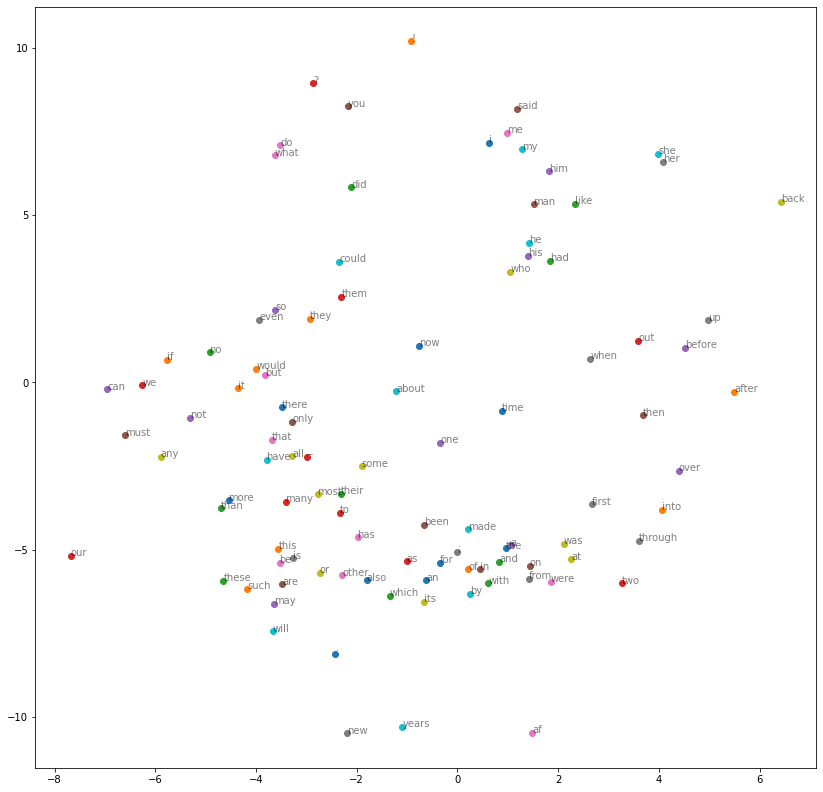

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
lookup=(y.embedding_layer1.emb_mat+y.embedding_layer2.emb_mat)
top_k=100
tsne = TSNE(metric='cosine')
embed_tsne = tsne.fit_transform(lookup[:300, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
        plt.scatter(*embed_tsne[idx, :])
        plt.annotate(y.i2w[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.5)
# after training